(ro_inventory_management:title)=
# Robust Inventory Management

In this case study, we consider a single-product inventory management problem discussed in {cite:ps}`Ben_Goryashko_Guslitzer_Nemirovski2004adjustable`, where there are one warehouse and $I$ factories. The production decision $\pmb{p}\in\mathbb{R}^{I\times T}$ is made for totally $T$ periods, and in each period $t$:

- $c_{it}$ is the cost of producing a unit of the product at a factory $i$;
- $d_t^0$ is the nominal demand for the product.

Other parameters are:
- $P_i$ is the maximum production capacity of the $i$th factory;
- $Q_i$ is the maximum cumulative production capacity of the $i$th factory throughout the planning horizon.
- $V_{\min}$ is the minimum allowed level of inventory at the warehouse;
- $V_{\max}$ is the maximum allowed level of inventory at the warehouse;

It is assumed that the demand of the product is uncertain and is characterized by the following box uncertainty set

$$
\mathcal{U} = \prod\limits_{t=1}^T [d_t^0 - \theta d_t^0, d_t^0 + \theta d_t^0],
$$

where $\theta$ is coefficient capturing the maximum relative deviation of the random demand from the nominal value. Here, we follow {cite:ps}`Ben_Goryashko_Guslitzer_Nemirovski2004adjustable` in configuring the problem for determining the production decision $\pmb{p}$ for $I=3$ factories over  $T=24$ time steps. These parameters are defined by the code segment below.

In [1]:
import numpy as np

T = 24
t = np.arange(1, T+1)
I = 3
i = np.arange(1, I+1)

d0 = 1000 * (1 + 0.5*np.sin(np.pi*(t-1)/12))
alpha = (0.5 + 0.5*i).reshape((3, 1))
c = alpha * (1 + 0.5*np.sin(np.pi*(t-1)/12))

P = 567
Q = 13600
Vmin = 500
Vmax = 2000
v0 = 500

theta = 0.2

The inventory management problem is solved as the following robust optimization model

$$
\begin{align}
\min~&\max\limits_{\pmb{d}\in\mathcal{U}}\sum\limits_{t=1}^{T}\sum\limits_{i=1}^I c_{it}p_{it}(\pmb{d}) \\
\text{s.t.}~&\min\limits_{\pmb{d}\in\mathcal{U}}p_{it}(\pmb{d}) \geq 0 && i\in [I]\text{ and }t\in [T] \\
&\max\limits_{\pmb{d}\in\mathcal{U}}p_{it}(\pmb{d})\leq P_{it}&& i\in [I]\text{ and }t\in [T] \\
&\max\limits_{\pmb{d}\in\mathcal{U}}\sum\limits_{t=1}^{T}p_{it}(\pmb{d}) \leq Q_i && i\in [I]\\
&\min\limits_{\pmb{d}\in\mathcal{U}}\left(v_0 + \sum\limits_{\tau=1}^{t-1}\sum\limits_{i=1}^Ip_{i\tau}(\pmb{d}) - \sum\limits_{\tau=1}^{t-1}\right) \geq V_{\min} && t\in [T] \\
&\max\limits_{\pmb{d}\in\mathcal{U}}\left(v_0 + \sum\limits_{\tau=1}^{t-1}\sum\limits_{i=1}^Ip_{i\tau}(\pmb{d}) - \sum\limits_{\tau=1}^{t-1}\right) \leq V_{\max} &&t\in [T]
\end{align}
$$

where the adaptive decision $p_{it}(\pmb{d})$ is approximated by the affine function

$$
p_{it}(\pmb{d}) = p_{it}^0 + \sum\limits_{\tau \in [t-1]}p_{it}^{\tau}d_{\tau},
$$

implying that the production decision $p_{it}$ affinely depends to uncertain demands up until time step $t-1$. In other words, it follows the affine decision rule $\mathcal{L}([t - 1])$. 

The robust model can be then solved using the RSOME package as below.

In [2]:
from rsome import ro

model = ro.Model()

d = model.rvar(T)
uset = (d >= (1-theta)*d0, 
        d <= (1+theta)*d0)

p = model.ldr((3, T)) 
for t in range(1, T):
    p[:, t].adapt(d[:t])

model.minmax((c*p).sum(), uset)
model.st(0 <= p, p <= P)
model.st(p.sum(axis=1) <= Q)
for t in range(T):
    model.st(v0 + p[:, :t+1].sum() - d[:t+1].sum() >= Vmin)
    model.st(v0 + p[:, :t+1].sum() - d[:t+1].sum() <= Vmax)

model.solve()

Being solved by the default LP solver...
Solution status: 0
Running time: 0.8551s


The objective value is given as below, which is consistent with the results provided in {cite:ps}`De_Brekelmans_Den2016impact`. 

In [3]:
wc_cost = model.get()
print(f'Objective: {wc_cost:.3f}')

Objective: 44272.827


Besides returning the objective value, the RSOME package also provides solution analysis tools for investigating the optimal solution of $\pmb{p}(\pmb{d})$. Notice that the adaptive decision $\pmb{p}(\pmb{d})$ is an affine function of the random demand $\pmb{d}$, so the value of $\pmb{d}$ must be provided for retrieving the optimal production decision, see the sample code below.

In [4]:
p0 = p(d.assign(d0))                 # The production schedule under the nominal demand
p_max = p(d.assign(d0 + theta*d0))   # The production schedule under the maximum demand
p_min = p(d.assign(d0 - theta*d0))   # The production schedule under the minimum demand

We can then plot the production decision under the nominal demand as follows.

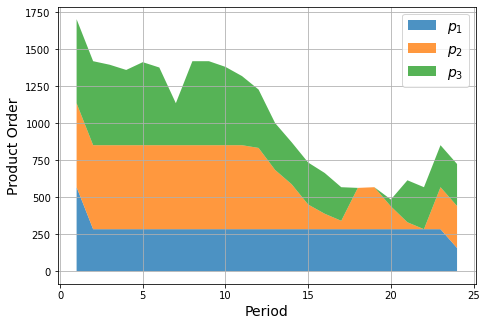

In [5]:
import matplotlib.pyplot as plt

periods = np.arange(1, T+1)

bottom = 0
plt.figure(figsize=(7.5, 5))
for i in range(I):
    plt.fill_between(periods, bottom, bottom + p0[i], alpha=0.8,
                     label=r'$p_{}$'.format(i+1))
    bottom += p0[i]

plt.legend(fontsize=14)
plt.xlabel('Period', fontsize=14)
plt.ylabel('Product Order', fontsize=14)
plt.grid()
plt.show()

We can also calculate the inventory level throughout the planning horizon using the `inventory_value()` function defined below, where the input argument `dvalue` specifies the realization of the random demand $\pmb{d}$. 

In [6]:
def inventory_value(dvalue):
    
    return v0 + (p(d.assign(dvalue)).sum(axis=0) - dvalue).cumsum()

The figure below depicts the inventory levels in the nominal case and under the maximum and minimum demands.

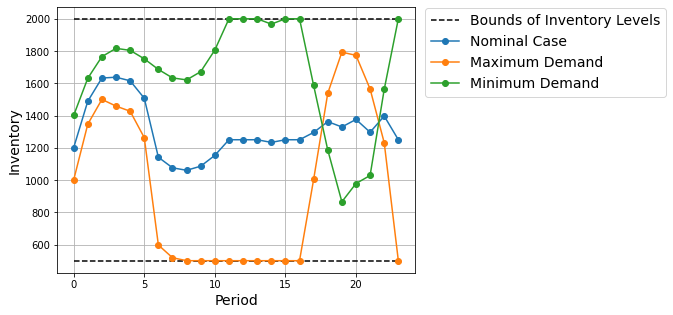

In [7]:
inv0 = inventory_value(d0)
inv_max = inventory_value(d0 + theta*d0)
inv_min = inventory_value(d0 - theta*d0)

plt.hlines(Vmin, 0, T-1, color='k', linestyle='--')
plt.hlines(Vmax, 0, T-1, color='k', linestyle='--', 
           label='Bounds of Inventory Levels')
plt.plot(inv0, marker='o', label='Nominal Case')
plt.plot(inv_max, marker='o', label='Maximum Demand')
plt.plot(inv_min, marker='o', label='Minimum Demand')
plt.legend(fontsize=14, bbox_to_anchor=(1.01, 1.02))
plt.grid()
plt.xlabel('Period', fontsize=14)
plt.ylabel('Inventory', fontsize=14)
plt.show()

As demonstrated in {cite:ps}`De_Brekelmans_Den2016impact`, this robust production-inventory problem can have multiple optimal solutions. All these optimal robust solutions share the same worst-case objective value, yet the affine decision rule $\pmb{p}(\pmb{d})$ can vary significantly, resulting in divergent performance under non-worst-case realizations. For instance, the use of different solvers to tackle the robust model may yield considerably distinct solutions.

Here, we reformulate the robust model as described in {cite:ps}`De_Brekelmans_Den2016impact`, with the objective of minimizing the nominal rather than the worst-case objective value. An additional constraint is introduced to ensure that the worst-case cost does not exceed `wc_cost`, i.e., the optimal cost of the previous robust model. It is noteworthy that the nominal objective can be expressed equivalently as the worst-case cost over an uncertainty set $\mathcal{Z}_0=\left\{\pmb{d}^0\right\}$—thus, enforcing $\pmb{d}$ to align with the nominal trajectory. The resolution of this new robust model is carried out through the following code.

In [8]:
from rsome import ro

model = ro.Model()

d = model.rvar(T)
uset = (d >= (1-theta)*d0, 
        d <= (1+theta)*d0)
uset0 = (d == d0)

a = model.dvar()
p = model.ldr((3, T)) 
for t in range(1, T):
    p[:, t].adapt(d[:t])

model.minmax(a, uset)
model.st(((c*p).sum() <= a).forall(uset0))
model.st((c*p).sum() <= wc_cost)
model.st(0 <= p, p <= P)
model.st(p.sum(axis=1) <= Q)
for t in range(T):
    model.st(v0 + p[:, :t+1].sum() - d[:t+1].sum() >= Vmin)
    model.st(v0 + p[:, :t+1].sum() - d[:t+1].sum() <= Vmax)

model.solve()

Being solved by the default LP solver...
Solution status: 0
Running time: 0.3415s


In the provided code segment, an intermediate variable `a` is introduced to represent the nominal case total cost, which is to be minimized as the model objective. The constraint `(c*p).sum() <= a` is imposed under the nominal case uncertainty set `uset0`, defined using the `forall()` method. Other constraints are enforced under the default uncertainty set `uset`, specified through the `minmax()` method in defining of the objective function.

The objective value printed below is the total production cost under the nominal demand trajectory. Please refer to Table 1 in {cite:ps}`De_Brekelmans_Den2016impact` to verify the worst-case and nominal production costs.

In [9]:
nom_cost = model.get()
print(f'Objective: {nom_cost:.3f}')

Objective: 35076.737


The optimal schedule under the nominal demand trajectory can also be plotted as follows. 

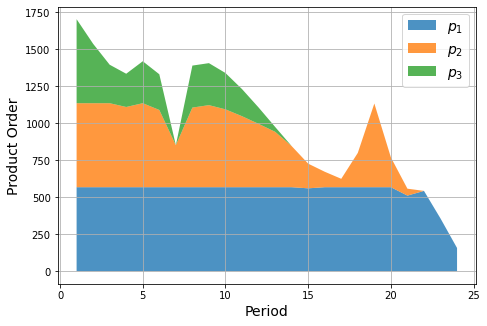

In [10]:
p0 = p(d.assign(d0))
periods = np.arange(1, T+1)

bottom = 0
plt.figure(figsize=(7.5, 5))
for i in range(I):
    plt.fill_between(periods, bottom, bottom + p0[i], alpha=0.8,
                     label=r'$p_{}$'.format(i+1))
    bottom += p0[i]

plt.legend(fontsize=14)
plt.xlabel('Period', fontsize=14)
plt.ylabel('Product Order', fontsize=14)
plt.grid()
plt.show()

The comparison reveals that the newly optimized production decision significantly differs from the previous one, despite both resulting in the same worst-case total cost.

<br>

---

<font size="5">Reference</font>

```{bibliography}
:filter: docname in docnames
```